In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, r2_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from collections import Counter
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import pickle
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

In [ ]:
# Cargar CSV en un DataFrame
train = pd.read_csv("train/train_set_bin.csv")
test = pd.read_csv("test/test_set_bin.csv")

In [11]:
train

,ID,Sex,Age,Height,Weight,Team,Games,City,Sport,Medal_bin
0,7496,F,26.0,161.000000,48.000000,South Korea,1992 Summer,Barcelona,Shooting,0
1,35953,M,37.0,178.000000,85.000000,Germany,1972 Winter,Sapporo,Bobsleigh,1
2,90861,M,21.0,200.000000,95.000000,United Kingdom,1996 Summer,Atlanta,Swimming,0
3,48204,F,27.0,165.042105,60.431579,United States,1996 Summer,Atlanta,Hockey,0
4,119167,F,22.0,164.000000,62.000000,Taiwan,1984 Winter,Sarajevo,Luge,0
...,...,...,...,...,...,...,...,...,...,...
142679,78964,M,26.0,191.000000,86.000000,United States,2012 Summer,London,Athletics,0
142680,116029,F,23.0,172.000000,63.000000,Czech Republic,1996 Summer,Atlanta,Judo,0
142681,113930,F,17.0,161.000000,50.000000,Italy,1976 Summer,Montreal,Gymnastics,0
142682,71790,M,24.0,178.000000,75.000000,United Kingdom,1984 Summer,Los Angeles,Swimming,0


In [12]:
X_train = train.drop(columns="Medal_bin")
y_train = train.Medal_bin
cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

In [1]:
# Encoder para columnas categóricas
encoder = TargetEncoder()
X_cat_encoded = encoder.fit_transform(X_train[cat_cols], y_train)
X_num = X_train[num_cols]  # columnas numéricas sin tocar
X_train_encoded = pd.concat([X_cat_encoded, X_num], axis=1)

# Balanceo de clases
counter = Counter(y_train)
n_major = counter[0]

smote = SMOTE(random_state=42, sampling_strategy={
    1: int(n_major*0.5)
})
undersample = RandomUnderSampler(sampling_strategy={0: int(n_major*0.8)}, random_state=42)

X_res, y_res = smote.fit_resample(X_train_encoded, y_train)
X_res, y_res = undersample.fit_resample(X_res, y_res)

NameError: name 'TargetEncoder' is not defined

In [ ]:
#Con los datos obtenidos en los analisis anteriores, sabemos que para nuestro dataset mal balanceado, 
# la tecnica que mejor funciona es un SMOTE + undersampling. Además, necesitamos hacer un TargetEncoder a las columnas categoricas como preprocesado.

#<<<<Pipeline>>>>
pipe = ImbPipeline(steps=[
    ('pca', PCA()),                   
    ('scaler', StandardScaler()),      
    ("feature_selection", SelectKBest(k=5, score_func=f_classif)),
    ('classifier', SVC(probability=True, class_weight='balanced'))
])

#<<<<Logistic classifier>>>>
logistic_params = {
    'pca__n_components': [3, 5, 7,], 
    'scaler': [StandardScaler(), MinMaxScaler()],
    'classifier': [
        LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')],
    "feature_selection__k": [3,5],
    'classifier__C':[0.1,1,10], 
    'classifier__penalty': ['l2']
}

#<<<<Random Forest>>>>
random_forest_params = {
    'pca__n_components': [3, 5],
    'scaler': [None],
    'classifier': [RandomForestClassifier(class_weight='balanced', n_jobs=-1)],
    'classifier__max_depth': [3, 5, None], 
    'classifier__n_estimators': [200],
    'classifier__max_features':['sqrt','log2']
}

#<<<Vector Soporte>>>>
svm_param = {
    'pca__n_components': [3, 5, 7,],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [SVC(class_weight='balanced')],
    'classifier__C': [0.1, 1, 5],
}


#<<<<<<XG Boost>>>>>>>
xgb_params = {
    'pca__n_components': [3, 5, 7,],
    'classifier': [XGBClassifier(random_state=42,n_jobs=-1)],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.1, 0.2],
}

#<<<<< Gradient Boosting Classifier>>>>>
gbct_params = {
    'pca__n_components': [3, 5, 7,],
    'scaler': [None],
    'classifier': [GradientBoostingClassifier(random_state=42)],
    'classifier__n_estimators': [100],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.1, 0.2],
}

#<<<<<Single Tree>>>>>

tree_params = {
    'pca__n_components': [3, 5, 7,],
    'classifier': [DecisionTreeClassifier(random_state=42)],
    'classifier__max_depth': [None, 3, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5]
}

#<<<<<ADA Boost>>>>>
ada_params = {
    'pca__n_components': [3, 5, 7,],
    'classifier': [AdaBoostClassifier(random_state=42)],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1]
}

results_modelos = []

search_space = [
    logistic_params,
    random_forest_params,
    #svm_param,
    xgb_params,
    gbct_params,
    tree_params,
    ada_params
]

#hacemos un bucle for para sacar una tabla con los mejores parametros de cada modelo y compararlos entre si
for params in search_space:
    # Extraer el nombre del modelo
    model_name = type(params['classifier'][0]).__name__

    clf_CV = GridSearchCV(estimator = pipe,
                    param_grid = [params],
                    cv = 3,
                    verbose=2,
                    n_jobs=-1)

    clf_CV.fit(X_res, y_res)

    results_modelos.append({
        'model': model_name,
        'best_score': clf_CV.best_score_,
        'best_params': clf_CV.best_params_,
        'best_estimator': clf_CV.best_estimator_

    })

df_results = pd.DataFrame(results_modelos)
display(df_results)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


,model,best_score,best_params,best_estimator
0,LogisticRegression,0.694979,{'classifier': LogisticRegression(class_weight...,"(PCA(n_components=7), MinMaxScaler(), SelectKB..."
1,RandomForestClassifier,0.767874,{'classifier': RandomForestClassifier(class_we...,"(PCA(n_components=5), None, SelectKBest(k=5), ..."
2,XGBClassifier,0.761712,"{'classifier': XGBClassifier(base_score=None, ...","(PCA(n_components=7), StandardScaler(), Select..."
3,GradientBoostingClassifier,0.752098,{'classifier': GradientBoostingClassifier(rand...,"(PCA(n_components=7), None, SelectKBest(k=5), ..."
4,DecisionTreeClassifier,0.740904,{'classifier': DecisionTreeClassifier(random_s...,"(PCA(n_components=7), StandardScaler(), Select..."
5,AdaBoostClassifier,0.716131,{'classifier': AdaBoostClassifier(random_state...,"(PCA(n_components=7), StandardScaler(), Select..."


In [20]:
#Ahora que tenemos que el mejor modelo es el RandomForestClassifier y XGBClassifier, vamos a intentar optimizarlo aún mas utilizando una primera vez RandomizedSearchCV

#<<<<Pipeline>>>>
pipe_opt = ImbPipeline(steps=[
('classifier', SVC(probability=True))
])

#<<<<Random Forest>>>>
random_forest_params = {
    'classifier': [RandomForestClassifier(class_weight='balanced', n_jobs=-1)],
    'classifier__max_depth': [5, None], 
    'classifier__n_estimators': [200,300],
    'classifier__max_features':['log2'],
    
}

#<<<<<<XG Boost>>>>>>>
xgb_params = {
    'classifier': [XGBClassifier(random_state=42,tree_method="hist",n_jobs=-1)],
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [3,5,7],
    'classifier__learning_rate': [0.2],
}

search_space1 = [
    random_forest_params,
    xgb_params
]

clf_random = RandomizedSearchCV(
    estimator=pipe_opt,
    param_distributions=search_space1,
    n_iter=100,
    cv=4,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [18]:
clf_random.fit(X_res, y_res)

c:\Users\Alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=70. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 10 candidates, totalling 40 fits


,estimator,Pipeline(step...ility=True))])
,param_distributions,"[{'classifier': [RandomForestC...d', n_jobs=-1)], 'classifier__max_depth': [5, None], 'classifier__max_features': ['log2'], 'classifier__n_estimators': [200, 300]}, {'classifier': [XGBClassifier...ree=None, ...)], 'classifier__learning_rate': [0.2], 'classifier__max_depth': [3, 5, ...], 'classifier__n_estimators': [200, 300]}]"
,n_iter,70
,scoring,None
,n_jobs,-1
,refit,True
,cv,4
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [19]:
print(clf_random.best_estimator_)
print(clf_random.best_score_)
print(clf_random.best_params_)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='log2', n_estimators=300,
                                        n_jobs=-1))])
0.878670961941864
{'classifier__n_estimators': 300, 'classifier__max_features': 'log2', 'classifier__max_depth': None, 'classifier': RandomForestClassifier(class_weight='balanced', n_jobs=-1)}


In [21]:
#Vemos que no hemos afinado mucho, volvemos a intentarlo con otros parámetros

#Hagamos una última optimización para ver si podemos llegar a 0.9. Esta vez con GridSearchCV y quedandonos ya solo con Random Forest

#<<<<Pipeline>>>>
pipeRF = ImbPipeline(steps=[
    ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
])

#<<<<Random Forest>>>>
random_forest_params_final = {
    'classifier__n_estimators': [300,350,400],
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [None],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_split': [2,5],
    'classifier__min_samples_leaf': [2,1]   
}

clf_CV_final = GridSearchCV(estimator = pipeRF,
                    param_grid = random_forest_params_final,
                    cv = 5,
                    verbose=2,
                    n_jobs=-1)

In [22]:
clf_CV_final.fit(X_res, y_res)
print(clf_CV_final.best_estimator_)
print(clf_CV_final.best_score_)
print(clf_CV_final.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='log2',
                                        min_samples_split=5, n_estimators=300,
                                        n_jobs=-1))])
0.887505942033411
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}


In [24]:
#Entrenamos con el modelo final incluyendo dentro del pipe el preproces para poder aplicar al test
# Encoder para columnas categóricas

# Pipeline FINAL sin CV
final_model_pipe = ImbPipeline(steps=[
    ('encoder', TargetEncoder()),
    ('smote', SMOTE(
        random_state=42,
        sampling_strategy={
            1: int(n_major * 0.5)
        }
    )),
    ('undersample', RandomUnderSampler(
        sampling_strategy={0: int(n_major * 0.8)},
        random_state=42
    )),

    ('classifier', RandomForestClassifier(
        n_estimators=300,
        criterion='gini',
        max_depth=None,
        max_features='log2',
        min_samples_split=5,
        min_samples_leaf=1,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

In [25]:
# ENTRENAR MODELO FINAL
final_model_pipe.fit(X_train, y_train)

,steps,"[('encoder', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['Sex', 'Team', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


In [26]:
# PREDICCIONES en train
y_pred_train = final_model_pipe.predict(X_train)
y_proba_train = final_model_pipe.predict_proba(X_train)

In [27]:
# Métricas de evaluación train 
accuracy = round(accuracy_score(y_train, y_pred_train),2)
f1 = round(f1_score(y_train, y_pred_train, average='weighted'),2)
precision = round(precision_score(y_train, y_pred_train, average='weighted'),2)
recall = round(recall_score(y_train, y_pred_train, average='weighted'),2)
conf_matrix = confusion_matrix(y_train, y_pred_train)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_train, y_pred_train))
print("\nMatriz de probabilidad:\n",y_proba_train)

Accuracy: 0.97
F1 Score: 0.97
Precision: 0.97
Recall: 0.97
Matriz de Confusión:
 [[120388   2825]
 [  2130  17341]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    123213
           1       0.86      0.89      0.87     19471

    accuracy                           0.97    142684
   macro avg       0.92      0.93      0.93    142684
weighted avg       0.97      0.97      0.97    142684


Matriz de probabilidad:
 [[0.97716426 0.02283574]
 [0.49814469 0.50185531]
 [0.69450154 0.30549846]
 ...
 [1.         0.        ]
 [0.95560747 0.04439253]
 [0.20651936 0.79348064]]


In [28]:
X_test = test.drop(columns="Medal_bin")
y_test = test.Medal_bin

In [29]:
y_pred = final_model_pipe.predict(X_test)
y_proba_test = final_model_pipe.predict_proba(X_test)

In [30]:
# Métricas de evaluación test 
accuracy = round(accuracy_score(y_test, y_pred),2)
f1 = round(f1_score(y_test, y_pred, average='weighted'),2)
precision = round(precision_score(y_test, y_pred, average='weighted'),2)
recall = round(recall_score(y_test, y_pred, average='weighted'),2)
conf_matrix = confusion_matrix(y_test, y_pred)
r2 = round(r2_score(y_test, y_pred),2)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
print("\nMatriz de probabilidad:\n",y_proba_test)

Accuracy: 0.89
F1 Score: 0.88
Precision: 0.88
Recall: 0.89
Matriz de Confusión:
 [[29333  1470]
 [ 2574  2294]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94     30803
           1       0.61      0.47      0.53      4868

    accuracy                           0.89     35671
   macro avg       0.76      0.71      0.73     35671
weighted avg       0.88      0.89      0.88     35671


Matriz de probabilidad:
 [[0.83710068 0.16289932]
 [0.26547724 0.73452276]
 [0.90377016 0.09622984]
 ...
 [0.96083623 0.03916377]
 [0.87080552 0.12919448]
 [0.88557441 0.11442559]]


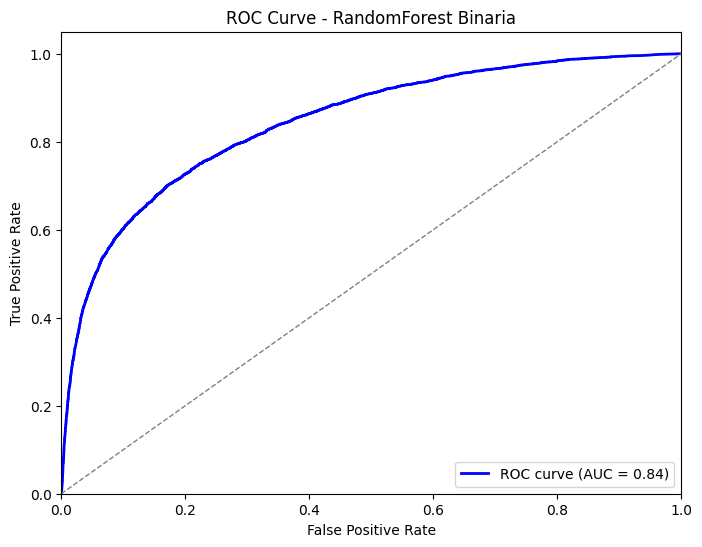

In [34]:
y_proba_roc = final_model_pipe.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_proba_roc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest Binaria')
plt.legend(loc="lower right")
plt.show()

In [35]:
pickle.dump(final_model_pipe, open('final_model_ML_binario.pkl', 'wb'))

In [38]:
modelo_importado = pickle.load(open("final_model_ML_binario.pkl", 'rb'))
modelo_importado

,steps,"[('encoder', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['Sex', 'Team', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


In [39]:
modelo_importado.predict(X_test)

array([0, 1, 0, ..., 0, 0, 0], shape=(35671,))